# SCANPY - PAGA - Differential analysis

In [1]:
#conda activate scRNA
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from matplotlib import rcParams
import scanpy as sc
import os
import csv
from astropy.io import ascii
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.cluster import DBSCAN
import warnings
from matplotlib_venn import venn3
from pathlib import Path
import sys
from itertools import combinations
from importlib import reload

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

warnings.filterwarnings('ignore')
code_dir = os.getcwd()
code_dir
sc.logging.print_versions()

scanpy==1.5.1 anndata==0.7.4 umap==0.4.4 numpy==1.19.2 scipy==1.5.2 pandas==1.0.5 scikit-learn==0.23.2 statsmodels==0.11.1 python-igraph==0.8.2 louvain==0.6.1 leidenalg==0.8.1


In [2]:
code_dir = os.getcwd()
base_dir = code_dir.replace("/codes_local","")
parent_dir = "/".join(base_dir.split("/")[:-1])
tools_dir = parent_dir + "/tools"

sys.path.insert(1, tools_dir)
import sc_addons
reload(sc_addons)

sp_name = base_dir.split("/")[-1]
analysis_name = ["0", "all"]

wk_dir = base_dir + "/1_Scanpy/%s-%s_Scanpy_out"%(analysis_name[0],analysis_name[1])
Path(wk_dir).mkdir(parents=True, exist_ok=True)

print(sp_name, analysis_name)

1_IL2RAKO ['0', 'all']


-----

### Info: IL2RAKOSc Expressional Level Differential Analysis
1. **Cluster v.s. Cluster** <br>
    1.1 One v.s. all <br>
    1.2 One v.s. one (with all cells) <br>

2. **WT v.s. KO** <br>
    2.1 KO v.s. WT v.s. Naive in all cells <br>
    2.2 KO v.s. WT in each cluster <br>

---

## 0. Read object

In [3]:
#--- adata object
sp_h5ad = wk_dir + '/' + sp_name + '_paga.h5ad'
adata = sc.read_h5ad(sp_h5ad)

# Remove genes that correlate with gender / Thy1
adata = adata[:, [True if x not in ["Xist", "Tsix", "Eif2s3y", "Ddx3y", "Thy1"] else False for x in adata.var.index]]

# Number of genes in adata object
gene_n = len(adata.raw.var)
gene_n

# Get set of labels
louvain_newlabel_uniq = list(set(adata.obs['louvain']))
louvain_newlabel_uniq.sort()
louvain_newlabel_uniq

#--- All genes from features.tsv
feature_file = base_dir + '/0_cellranger_outs_XL_folder/outs/filtered_feature_bc_matrix/features.tsv'
features_df = pd.read_csv(feature_file, header=None, sep='\t')
all_genes = list(features_df[1])

In [4]:
de_dir = wk_dir + '/2_DE'
Path(de_dir).mkdir(parents=True, exist_ok=True)

sc.pl.violin(adata, 'G6pdx', groupby="louvain_newlabel", save="G6pdx_violin.png")
sc.pl.violin(adata, 'Mki67',groupby="louvain_newlabel", save="Mki67_violin.png")
sc.pl.paga(adata, color=['louvain'], save="node_plot.pdf")

-----

<h1><font size="8"><center> 1. Cluster versus Cluster </center></font></h1>

# 1.1 Differential Analysis for All Clusters

In [5]:
# Working directory
cp_dir = de_dir + '/eachCluster_vs_All'
Path(cp_dir).mkdir(parents=True, exist_ok=True)

obs_useCol = 'louvain'
label_useCol = 'louvain'
labels_uniq = list(set(adata.obs[label_useCol]))
labels_uniq.sort()

### 1.1.1 T-test

Trying to set attribute `.uns` of view, copying.


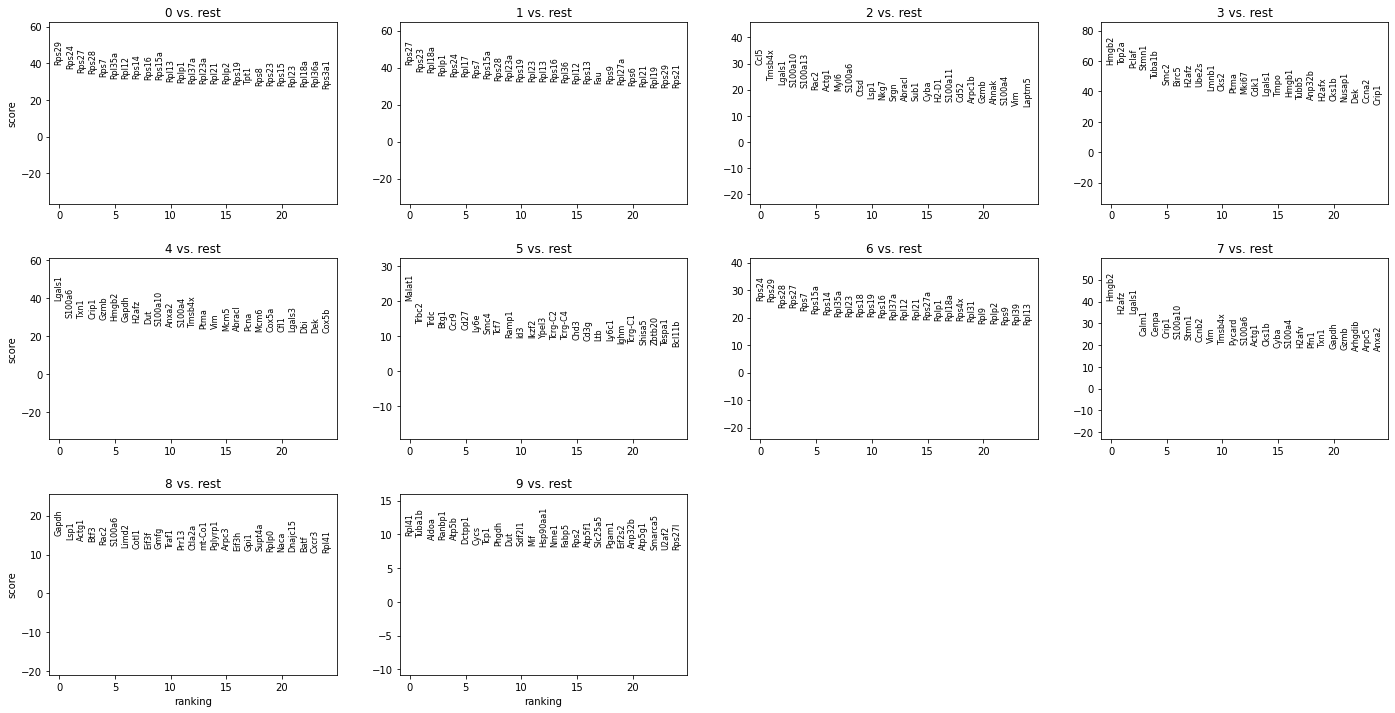

In [6]:
sc.tl.rank_genes_groups(adata, obs_useCol, method='t-test', key_added='t-test',n_genes=gene_n)
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, key='t-test')

### 1.1.2 T-test overestimated variance

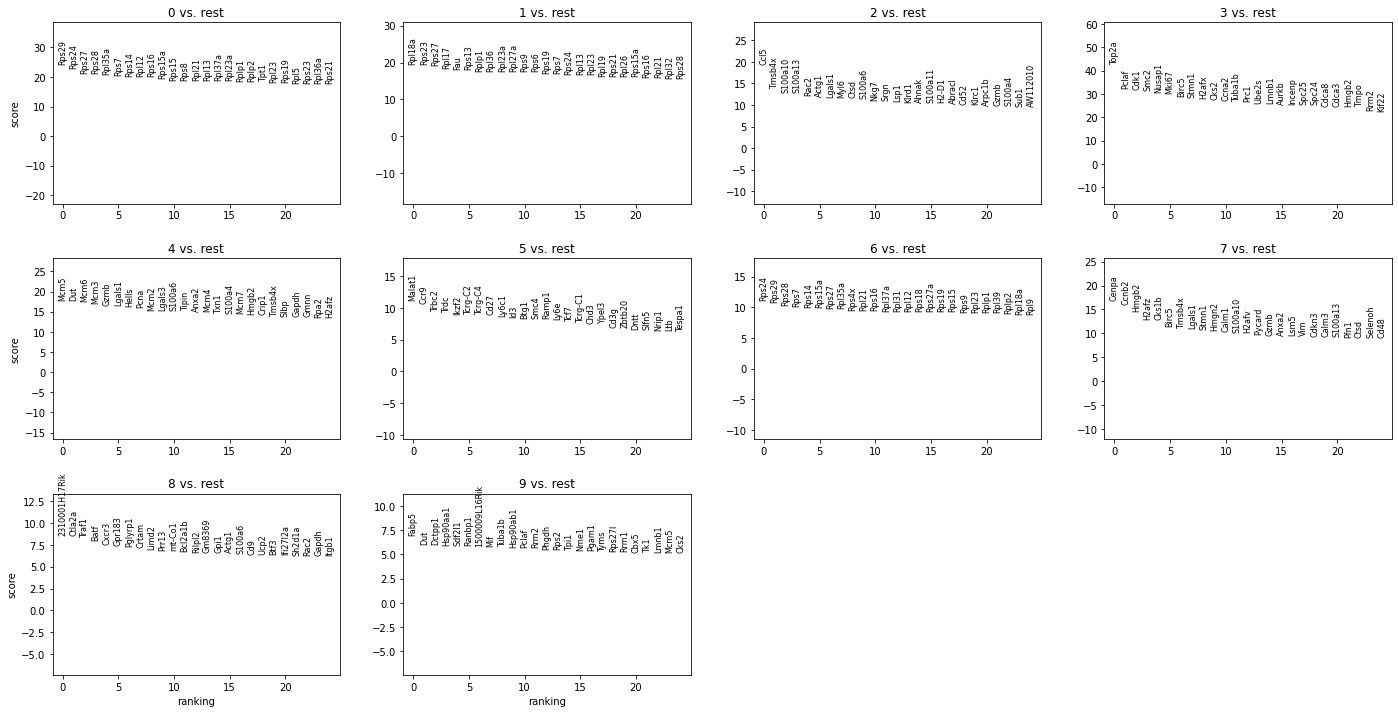

In [7]:
sc.tl.rank_genes_groups(adata, obs_useCol, method='t-test_overestim_var', key_added = "t-test_ov",n_genes=gene_n)
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, key = "t-test_ov")

### 1.1.3 Wilconxon rank-sum

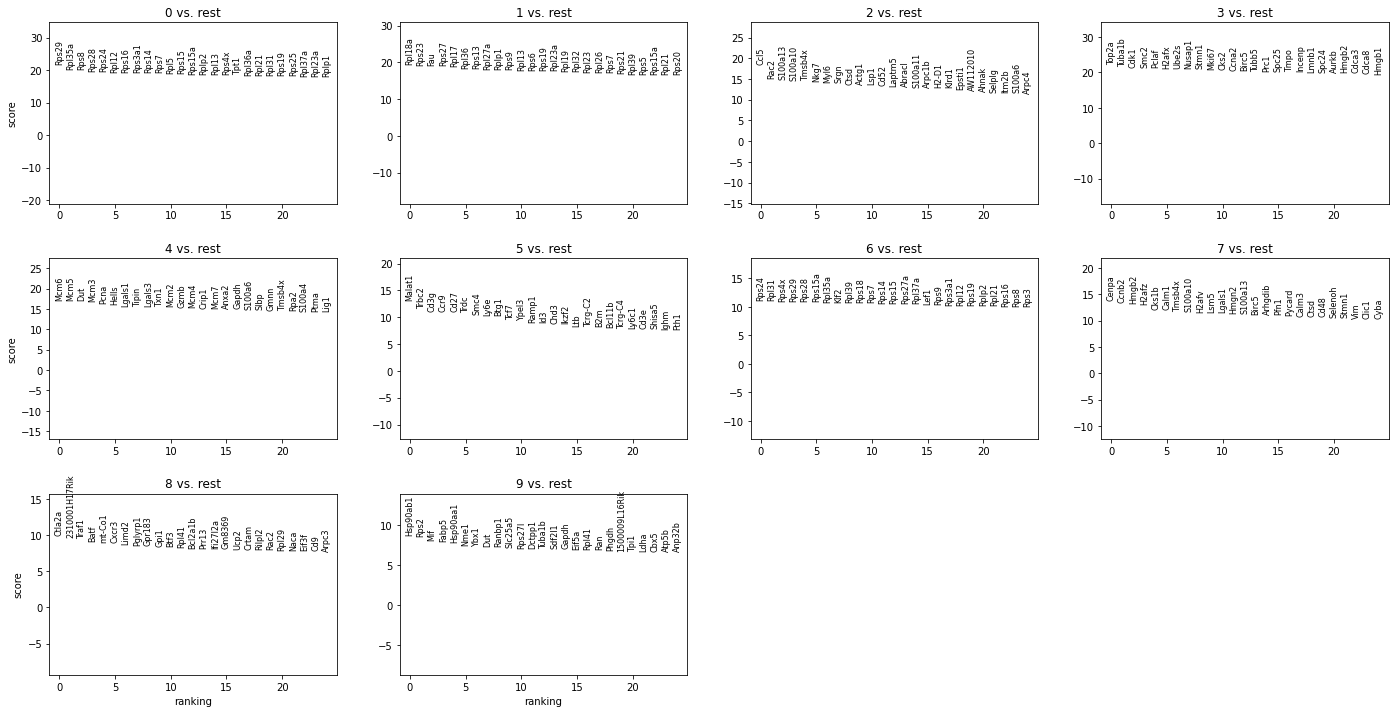

In [8]:
sc.tl.rank_genes_groups(adata, obs_useCol, method='wilcoxon', key_added = "wilcoxon",n_genes=gene_n)
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, key="wilcoxon")

### 1.1.4 Logistic regression

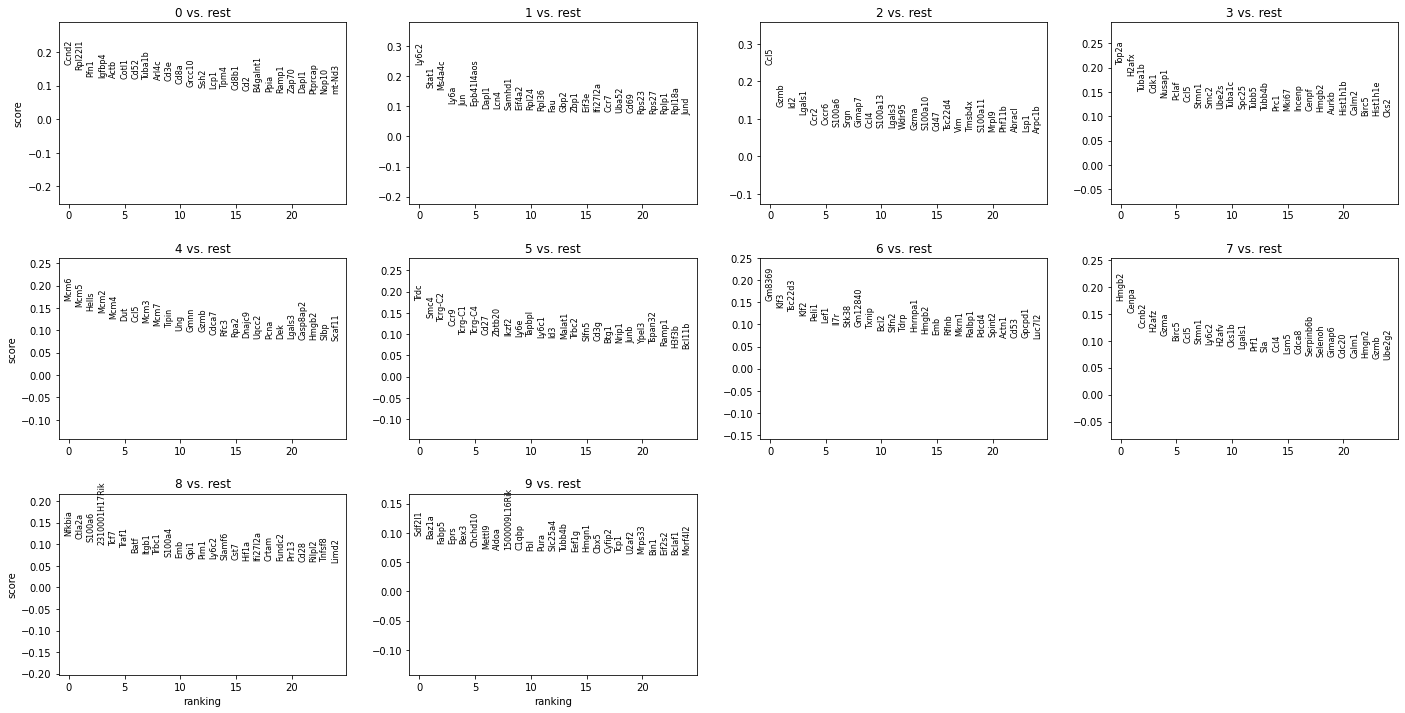

In [9]:
sc.tl.rank_genes_groups(adata, obs_useCol, method='logreg',key_added = "logreg",n_genes=gene_n)
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, key = "logreg")

### 1.1.5 Compare genes

In [10]:
###Redo
os.chdir(cp_dir)

cps = ['wilcoxon', 't-test', 't-test_ov','logreg']


for l_t in labels_uniq:
    genes_df_l_t = pd.DataFrame({"gene_names":all_genes})
    dict_l_t = {}
    for cp in cps:
        if cp != 'logreg':
            cp_names = adata.uns[cp]['names'][l_t]
            cp_fc = adata.uns[cp]['logfoldchanges'][l_t]
            cp_score = adata.uns[cp]['scores'][l_t]
            cp_padj = adata.uns[cp]['pvals_adj'][l_t]
            if (cp == 't-test_ov'):
                cp_name = 't-test_overestim_var'
                cp_df = pd.DataFrame({"gene_names":cp_names, "%s_logfc"%cp_name: cp_fc, "%s_padj"%cp_name:cp_padj, "%s_score"%cp_name:cp_score})
            else:
                cp_df = pd.DataFrame({"gene_names":cp_names, "%s_logfc"%cp: cp_fc, "%s_padj"%cp:cp_padj, "%s_score"%cp:cp_score})

            genes_df_l_t = pd.merge(genes_df_l_t, cp_df, how='outer', on="gene_names")
            cp_df = cp_df[cp_df[cp_df.columns[2]] <= 0.05]
            cp_df = cp_df[cp_df[cp_df.columns[1]] > 0]
            dict_l_t[cp] = cp_df['gene_names']
        else:
            cp_names = adata.uns[cp]['names'][l_t]
            cp_score = adata.uns[cp]['scores'][l_t]
            cp_df = pd.DataFrame({"gene_names":cp_names,  "%s_score"%cp:cp_score})
            genes_df_l_t = pd.merge(genes_df_l_t, cp_df, how='outer', on="gene_names")
    genes_df_l_t.to_csv("%s_differential.csv"%l_t, index=False)
    
    venn3([set(dict_l_t[cps[0]]), set(dict_l_t[cps[1]]), set(dict_l_t[cps[2]])], tuple(cps[:3]))
    
    outname = "%s_venn.png"%l_t
    plt.savefig(outname)
    plt.close()

### 1.1.6 Visualization

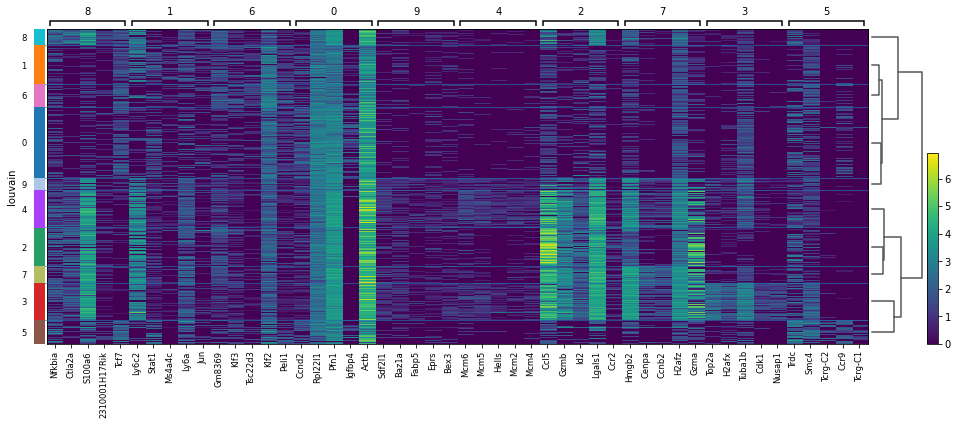

In [11]:
heatmap = sc.pl.rank_genes_groups_heatmap(adata, n_genes=5, key="logreg", groupby=obs_useCol, 
                                          show_gene_labels=True,save="logreg_heatmap.png")

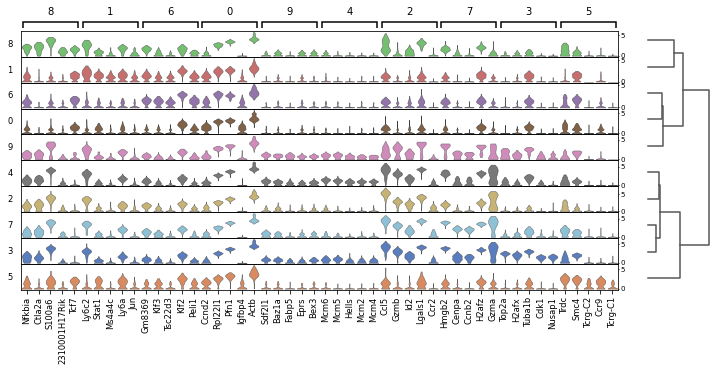

In [12]:
sc.pl.rank_genes_groups_stacked_violin(adata, n_genes=5, key="logreg", groupby=obs_useCol,
                                      save="logreg_violin.png")

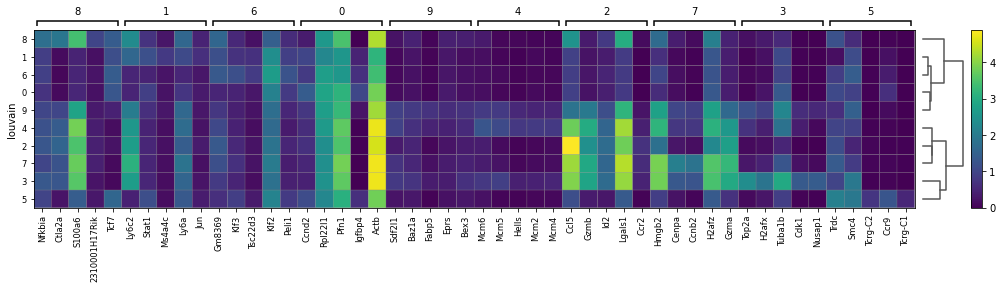

In [13]:
sc.pl.rank_genes_groups_matrixplot(adata, n_genes=5, key="logreg", groupby=obs_useCol,
                                  save="logreg_matrix.png")

-----
# 1.2 Compare specific clusters

In [14]:
# Working directory
cp_dir = de_dir + '/Cluster_vs_Cluster'
Path(cp_dir).mkdir(parents=True, exist_ok=True)

['0', '1']


Trying to set attribute `.uns` of view, copying.


0 1 wilcoxon
0 1 t-test
0 1 t-test_overestim_var


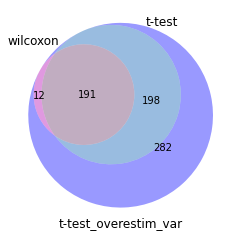

1 0 wilcoxon
1 0 t-test
1 0 t-test_overestim_var


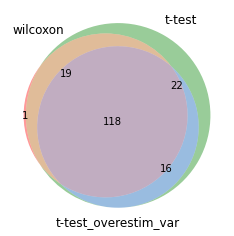

['0', '2']


Trying to set attribute `.uns` of view, copying.


0 2 wilcoxon
0 2 t-test
0 2 t-test_overestim_var


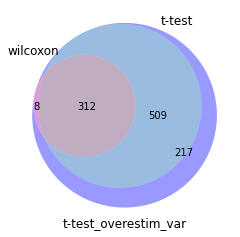

2 0 wilcoxon
2 0 t-test
2 0 t-test_overestim_var


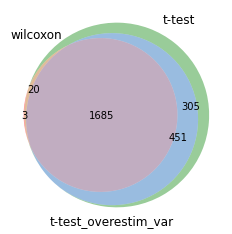

['0', '3']


Trying to set attribute `.uns` of view, copying.


0 3 wilcoxon
0 3 t-test
0 3 t-test_overestim_var


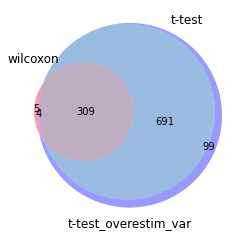

3 0 wilcoxon
3 0 t-test
3 0 t-test_overestim_var


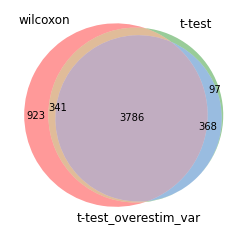

['0', '4']


Trying to set attribute `.uns` of view, copying.


0 4 wilcoxon
0 4 t-test
0 4 t-test_overestim_var


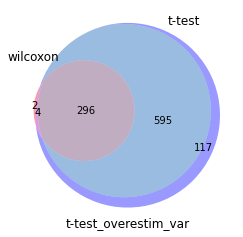

4 0 wilcoxon
4 0 t-test
4 0 t-test_overestim_var


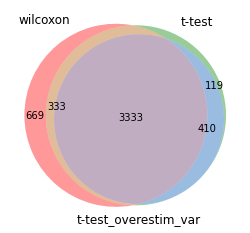

['0', '5']


Trying to set attribute `.uns` of view, copying.


0 5 wilcoxon
0 5 t-test
0 5 t-test_overestim_var


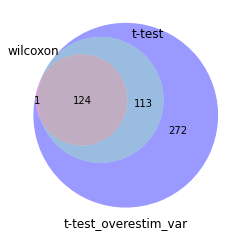

5 0 wilcoxon
5 0 t-test
5 0 t-test_overestim_var


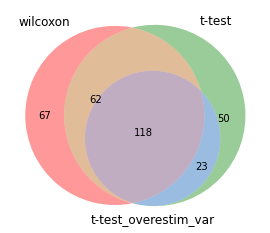

['0', '6']


Trying to set attribute `.uns` of view, copying.


0 6 wilcoxon
0 6 t-test
0 6 t-test_overestim_var


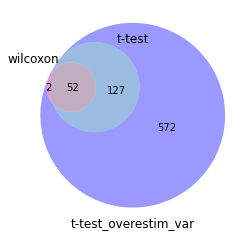

6 0 wilcoxon
6 0 t-test
6 0 t-test_overestim_var


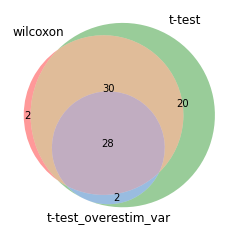

['0', '7']


Trying to set attribute `.uns` of view, copying.


0 7 wilcoxon
0 7 t-test
0 7 t-test_overestim_var


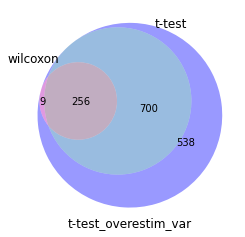

7 0 wilcoxon
7 0 t-test
7 0 t-test_overestim_var


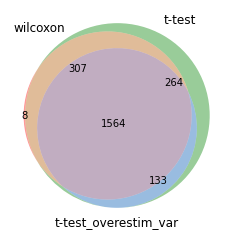

['0', '8']


Trying to set attribute `.uns` of view, copying.


0 8 wilcoxon
0 8 t-test
0 8 t-test_overestim_var


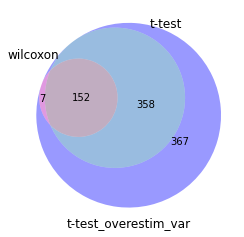

8 0 wilcoxon
8 0 t-test
8 0 t-test_overestim_var


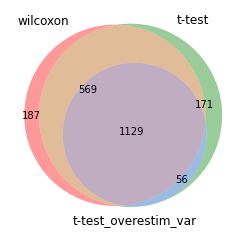

['0', '9']


Trying to set attribute `.uns` of view, copying.


0 9 wilcoxon
0 9 t-test
0 9 t-test_overestim_var


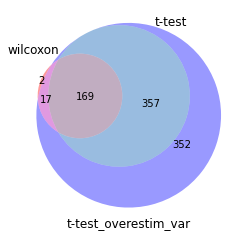

9 0 wilcoxon
9 0 t-test
9 0 t-test_overestim_var


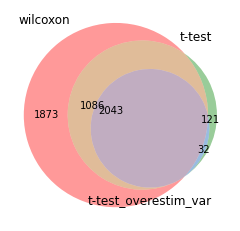

['0', '1']


Trying to set attribute `.uns` of view, copying.


0 1 wilcoxon
0 1 t-test
0 1 t-test_overestim_var


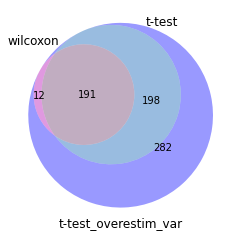

1 0 wilcoxon
1 0 t-test
1 0 t-test_overestim_var


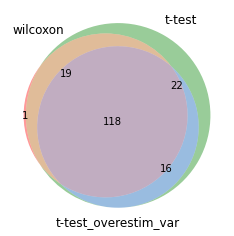

['1', '2']


Trying to set attribute `.uns` of view, copying.


1 2 wilcoxon
1 2 t-test
1 2 t-test_overestim_var


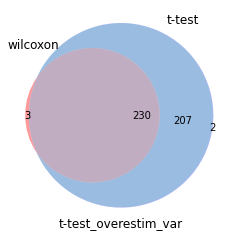

2 1 wilcoxon
2 1 t-test
2 1 t-test_overestim_var


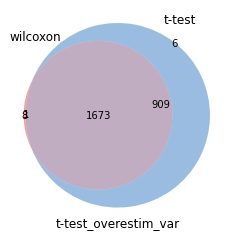

['1', '3']


Trying to set attribute `.uns` of view, copying.


1 3 wilcoxon
1 3 t-test
1 3 t-test_overestim_var


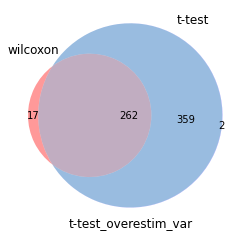

3 1 wilcoxon
3 1 t-test
3 1 t-test_overestim_var


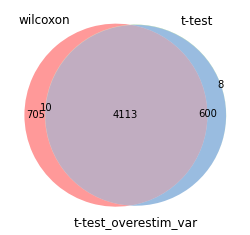

['1', '4']


Trying to set attribute `.uns` of view, copying.


1 4 wilcoxon
1 4 t-test
1 4 t-test_overestim_var


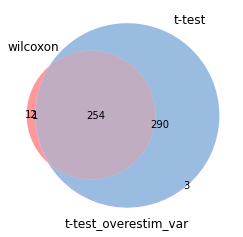

4 1 wilcoxon
4 1 t-test
4 1 t-test_overestim_var


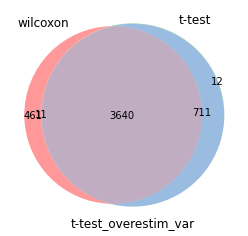

['1', '5']


Trying to set attribute `.uns` of view, copying.


1 5 wilcoxon
1 5 t-test
1 5 t-test_overestim_var


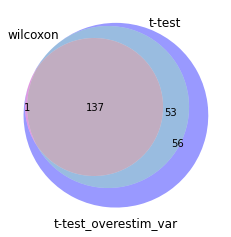

5 1 wilcoxon
5 1 t-test
5 1 t-test_overestim_var


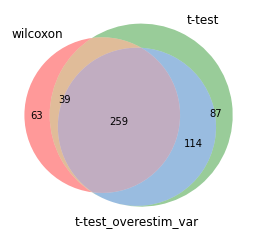

['1', '6']


Trying to set attribute `.uns` of view, copying.


1 6 wilcoxon
1 6 t-test
1 6 t-test_overestim_var


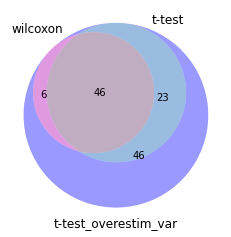

6 1 wilcoxon
6 1 t-test
6 1 t-test_overestim_var


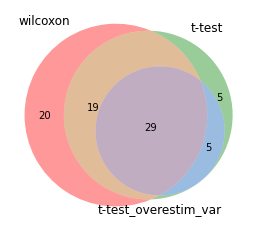

['1', '7']


Trying to set attribute `.uns` of view, copying.


1 7 wilcoxon
1 7 t-test
1 7 t-test_overestim_var


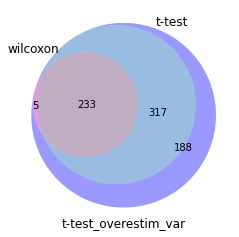

7 1 wilcoxon
7 1 t-test
7 1 t-test_overestim_var


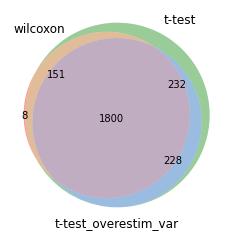

['1', '8']


Trying to set attribute `.uns` of view, copying.


1 8 wilcoxon
1 8 t-test
1 8 t-test_overestim_var


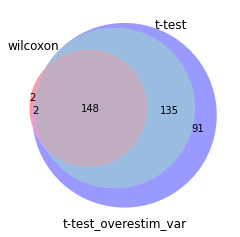

8 1 wilcoxon
8 1 t-test
8 1 t-test_overestim_var


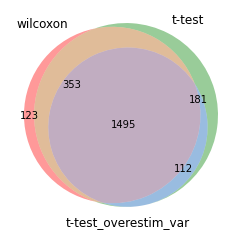

['1', '9']


Trying to set attribute `.uns` of view, copying.


1 9 wilcoxon
1 9 t-test
1 9 t-test_overestim_var


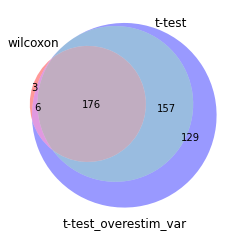

9 1 wilcoxon
9 1 t-test
9 1 t-test_overestim_var


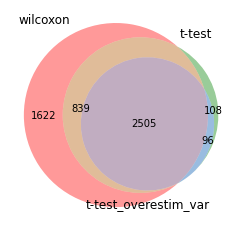

['0', '2']


Trying to set attribute `.uns` of view, copying.


0 2 wilcoxon
0 2 t-test
0 2 t-test_overestim_var


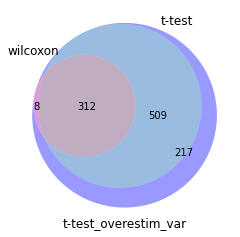

2 0 wilcoxon
2 0 t-test
2 0 t-test_overestim_var


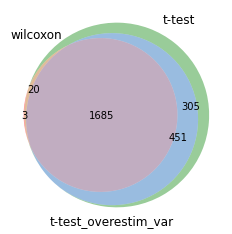

['1', '2']


Trying to set attribute `.uns` of view, copying.


1 2 wilcoxon
1 2 t-test
1 2 t-test_overestim_var


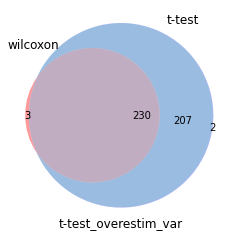

2 1 wilcoxon
2 1 t-test
2 1 t-test_overestim_var


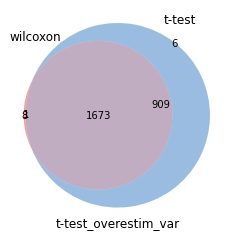

['2', '3']


Trying to set attribute `.uns` of view, copying.


2 3 wilcoxon
2 3 t-test
2 3 t-test_overestim_var


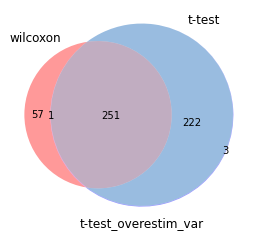

3 2 wilcoxon
3 2 t-test
3 2 t-test_overestim_var


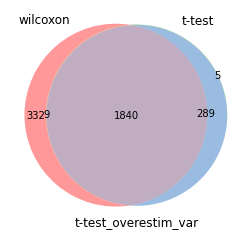

['2', '4']


Trying to set attribute `.uns` of view, copying.


2 4 wilcoxon
2 4 t-test
2 4 t-test_overestim_var


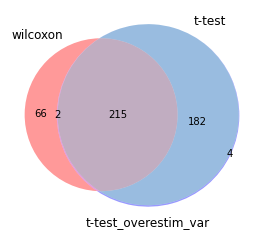

4 2 wilcoxon
4 2 t-test
4 2 t-test_overestim_var


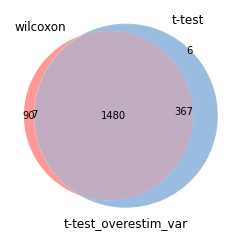

['2', '5']


Trying to set attribute `.uns` of view, copying.


2 5 wilcoxon
2 5 t-test
2 5 t-test_overestim_var


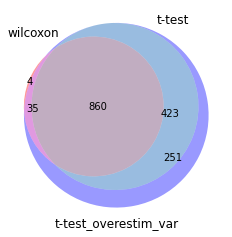

5 2 wilcoxon
5 2 t-test
5 2 t-test_overestim_var


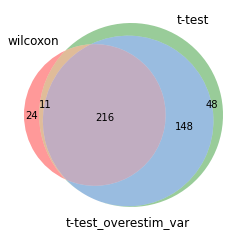

['2', '6']


Trying to set attribute `.uns` of view, copying.


2 6 wilcoxon
2 6 t-test
2 6 t-test_overestim_var


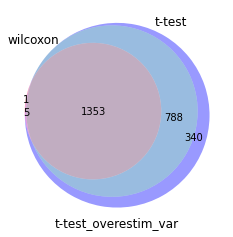

6 2 wilcoxon
6 2 t-test
6 2 t-test_overestim_var


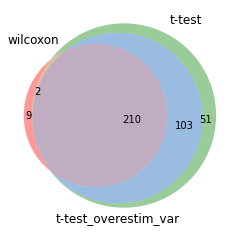

['2', '7']


Trying to set attribute `.uns` of view, copying.


2 7 wilcoxon
2 7 t-test
2 7 t-test_overestim_var


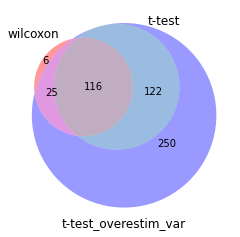

7 2 wilcoxon
7 2 t-test
7 2 t-test_overestim_var


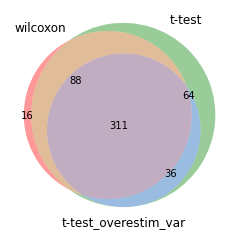

['2', '8']


Trying to set attribute `.uns` of view, copying.


2 8 wilcoxon
2 8 t-test
2 8 t-test_overestim_var


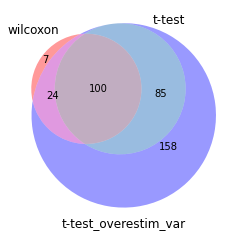

8 2 wilcoxon
8 2 t-test
8 2 t-test_overestim_var


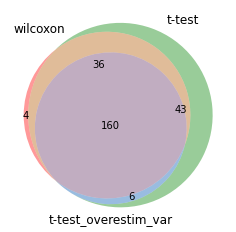

['2', '9']


Trying to set attribute `.uns` of view, copying.


2 9 wilcoxon
2 9 t-test
2 9 t-test_overestim_var


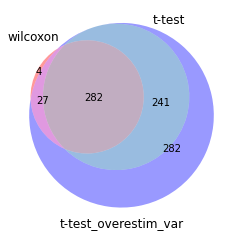

9 2 wilcoxon
9 2 t-test
9 2 t-test_overestim_var


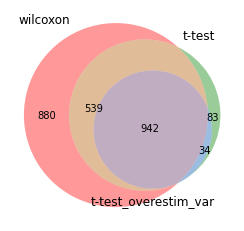

['0', '3']


Trying to set attribute `.uns` of view, copying.


0 3 wilcoxon
0 3 t-test
0 3 t-test_overestim_var


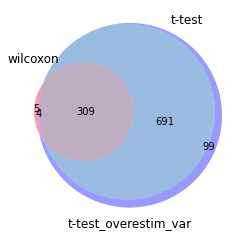

3 0 wilcoxon
3 0 t-test
3 0 t-test_overestim_var


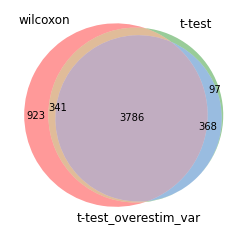

['1', '3']


Trying to set attribute `.uns` of view, copying.


1 3 wilcoxon
1 3 t-test
1 3 t-test_overestim_var


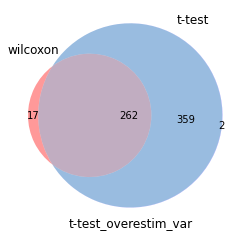

3 1 wilcoxon
3 1 t-test
3 1 t-test_overestim_var


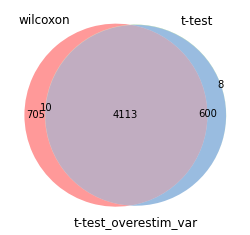

['2', '3']


Trying to set attribute `.uns` of view, copying.


2 3 wilcoxon
2 3 t-test
2 3 t-test_overestim_var


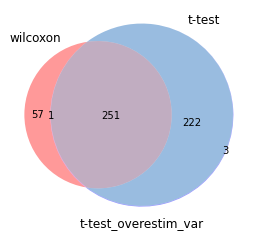

3 2 wilcoxon
3 2 t-test
3 2 t-test_overestim_var


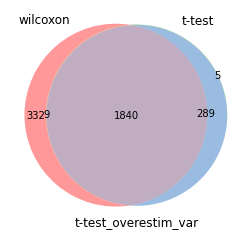

['3', '4']


Trying to set attribute `.uns` of view, copying.


3 4 wilcoxon
3 4 t-test
3 4 t-test_overestim_var


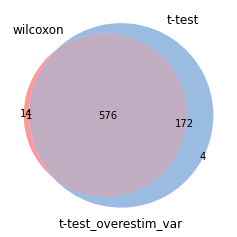

4 3 wilcoxon
4 3 t-test
4 3 t-test_overestim_var


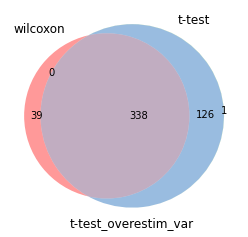

['3', '5']


Trying to set attribute `.uns` of view, copying.


3 5 wilcoxon
3 5 t-test
3 5 t-test_overestim_var


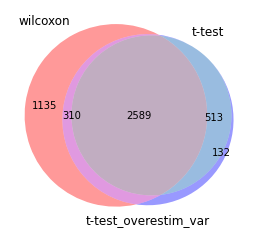

5 3 wilcoxon
5 3 t-test
5 3 t-test_overestim_var


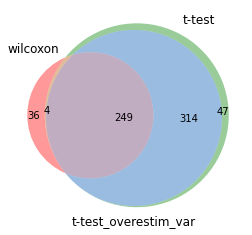

['3', '6']


Trying to set attribute `.uns` of view, copying.


3 6 wilcoxon
3 6 t-test
3 6 t-test_overestim_var


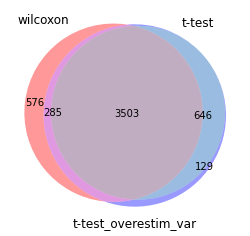

6 3 wilcoxon
6 3 t-test
6 3 t-test_overestim_var


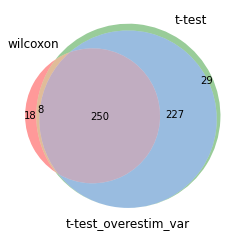

['3', '7']


Trying to set attribute `.uns` of view, copying.


3 7 wilcoxon
3 7 t-test
3 7 t-test_overestim_var


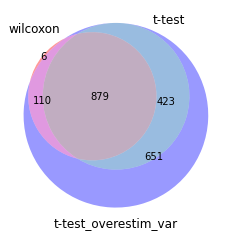

7 3 wilcoxon
7 3 t-test
7 3 t-test_overestim_var


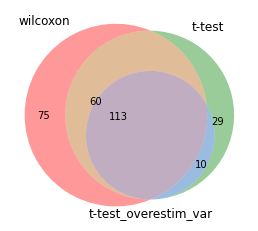

['3', '8']


Trying to set attribute `.uns` of view, copying.


3 8 wilcoxon
3 8 t-test
3 8 t-test_overestim_var


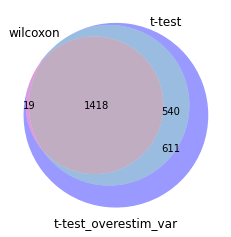

8 3 wilcoxon
8 3 t-test
8 3 t-test_overestim_var


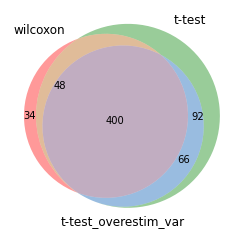

['3', '9']


Trying to set attribute `.uns` of view, copying.


3 9 wilcoxon
3 9 t-test
3 9 t-test_overestim_var


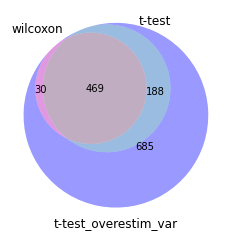

9 3 wilcoxon
9 3 t-test
9 3 t-test_overestim_var


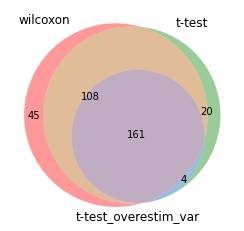

['0', '4']


Trying to set attribute `.uns` of view, copying.


0 4 wilcoxon
0 4 t-test
0 4 t-test_overestim_var


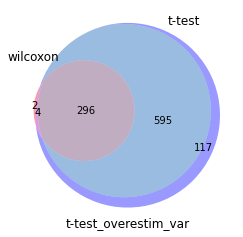

4 0 wilcoxon
4 0 t-test
4 0 t-test_overestim_var


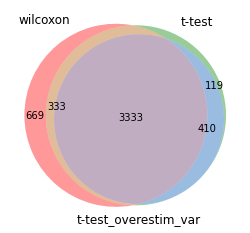

['1', '4']


Trying to set attribute `.uns` of view, copying.


1 4 wilcoxon
1 4 t-test
1 4 t-test_overestim_var


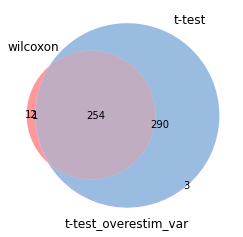

4 1 wilcoxon
4 1 t-test
4 1 t-test_overestim_var


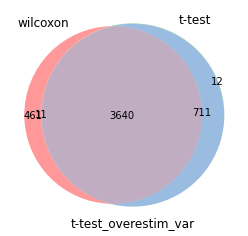

['2', '4']


Trying to set attribute `.uns` of view, copying.


2 4 wilcoxon
2 4 t-test
2 4 t-test_overestim_var


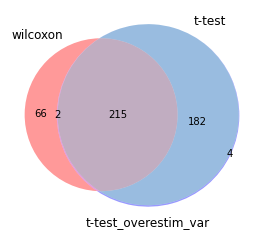

4 2 wilcoxon
4 2 t-test
4 2 t-test_overestim_var


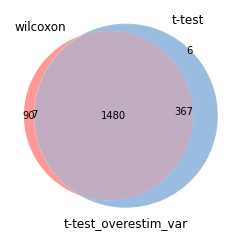

['3', '4']


Trying to set attribute `.uns` of view, copying.


3 4 wilcoxon
3 4 t-test
3 4 t-test_overestim_var


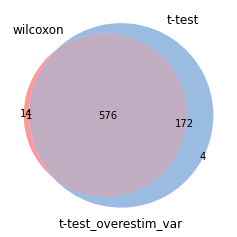

4 3 wilcoxon
4 3 t-test
4 3 t-test_overestim_var


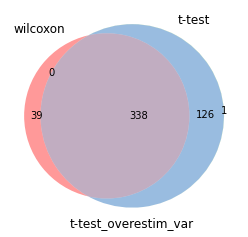

['4', '5']


Trying to set attribute `.uns` of view, copying.


4 5 wilcoxon
4 5 t-test
4 5 t-test_overestim_var


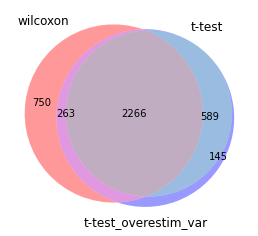

5 4 wilcoxon
5 4 t-test
5 4 t-test_overestim_var


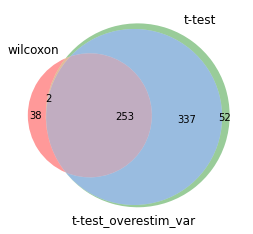

['4', '6']


Trying to set attribute `.uns` of view, copying.


4 6 wilcoxon
4 6 t-test
4 6 t-test_overestim_var


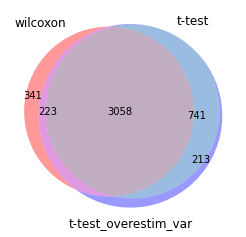

6 4 wilcoxon
6 4 t-test
6 4 t-test_overestim_var


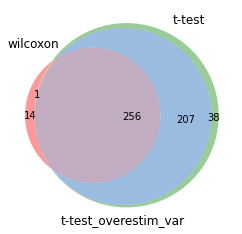

['4', '7']


Trying to set attribute `.uns` of view, copying.


4 7 wilcoxon
4 7 t-test
4 7 t-test_overestim_var


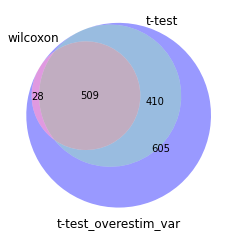

7 4 wilcoxon
7 4 t-test
7 4 t-test_overestim_var


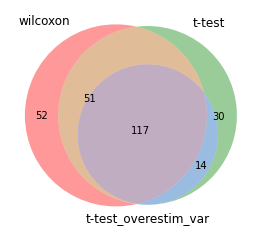

['4', '8']


Trying to set attribute `.uns` of view, copying.


4 8 wilcoxon
4 8 t-test
4 8 t-test_overestim_var


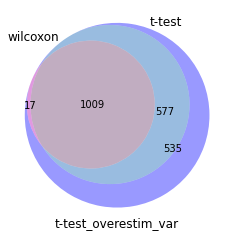

8 4 wilcoxon
8 4 t-test
8 4 t-test_overestim_var


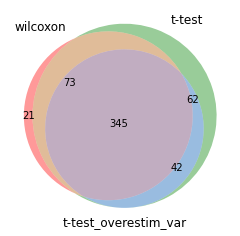

['4', '9']


Trying to set attribute `.uns` of view, copying.


4 9 wilcoxon
4 9 t-test
4 9 t-test_overestim_var


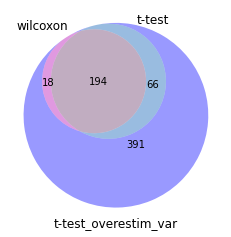

9 4 wilcoxon
9 4 t-test
9 4 t-test_overestim_var


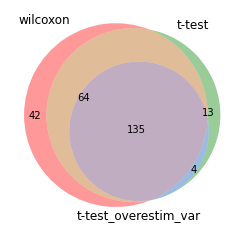

['0', '5']


Trying to set attribute `.uns` of view, copying.


0 5 wilcoxon
0 5 t-test
0 5 t-test_overestim_var


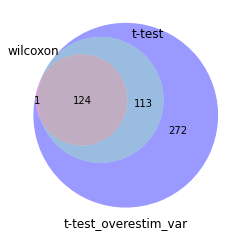

5 0 wilcoxon
5 0 t-test
5 0 t-test_overestim_var


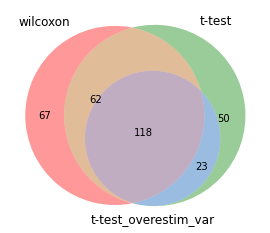

['1', '5']


Trying to set attribute `.uns` of view, copying.


1 5 wilcoxon
1 5 t-test
1 5 t-test_overestim_var


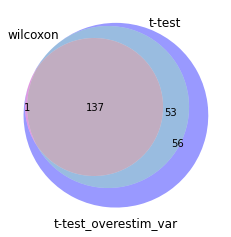

5 1 wilcoxon
5 1 t-test
5 1 t-test_overestim_var


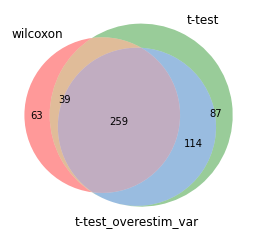

['2', '5']


Trying to set attribute `.uns` of view, copying.


2 5 wilcoxon
2 5 t-test
2 5 t-test_overestim_var


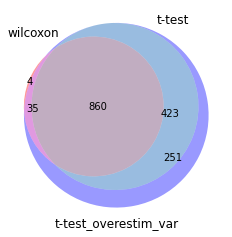

5 2 wilcoxon
5 2 t-test
5 2 t-test_overestim_var


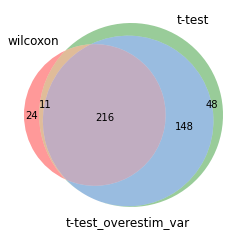

['3', '5']


Trying to set attribute `.uns` of view, copying.


3 5 wilcoxon
3 5 t-test
3 5 t-test_overestim_var


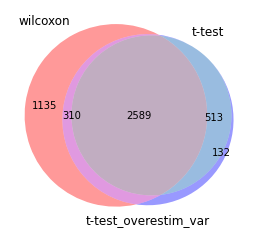

5 3 wilcoxon
5 3 t-test
5 3 t-test_overestim_var


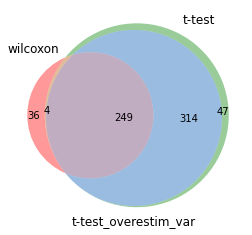

['4', '5']


Trying to set attribute `.uns` of view, copying.


4 5 wilcoxon
4 5 t-test
4 5 t-test_overestim_var


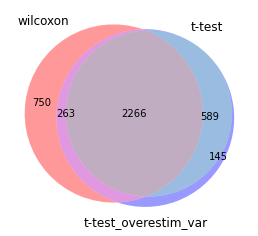

5 4 wilcoxon
5 4 t-test
5 4 t-test_overestim_var


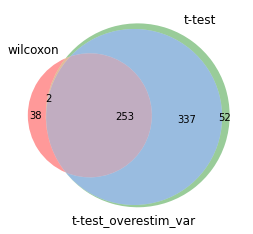

['5', '6']


Trying to set attribute `.uns` of view, copying.


5 6 wilcoxon
5 6 t-test
5 6 t-test_overestim_var


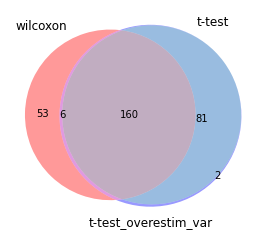

6 5 wilcoxon
6 5 t-test
6 5 t-test_overestim_var


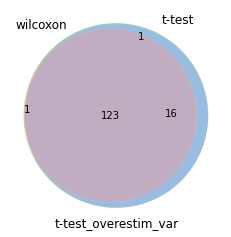

['5', '7']


Trying to set attribute `.uns` of view, copying.


5 7 wilcoxon
5 7 t-test
5 7 t-test_overestim_var


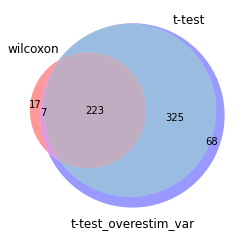

7 5 wilcoxon
7 5 t-test
7 5 t-test_overestim_var


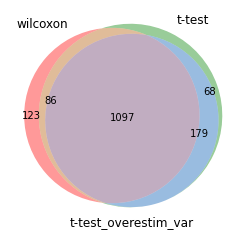

['5', '8']


Trying to set attribute `.uns` of view, copying.


5 8 wilcoxon
5 8 t-test
5 8 t-test_overestim_var


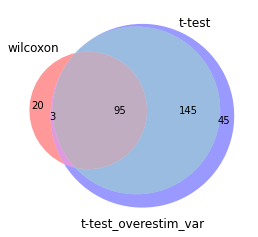

8 5 wilcoxon
8 5 t-test
8 5 t-test_overestim_var


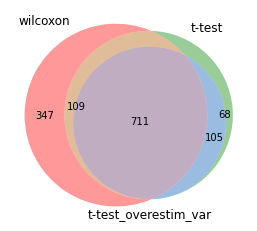

['5', '9']


Trying to set attribute `.uns` of view, copying.


5 9 wilcoxon
5 9 t-test
5 9 t-test_overestim_var


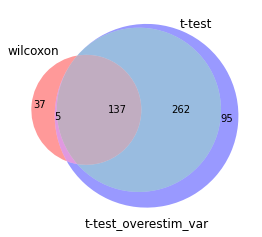

9 5 wilcoxon
9 5 t-test
9 5 t-test_overestim_var


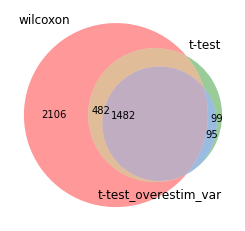

['0', '6']


Trying to set attribute `.uns` of view, copying.


0 6 wilcoxon
0 6 t-test
0 6 t-test_overestim_var


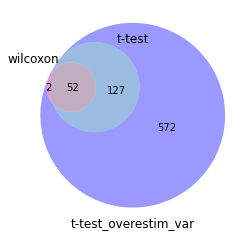

6 0 wilcoxon
6 0 t-test
6 0 t-test_overestim_var


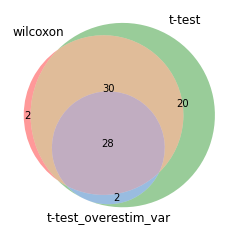

['1', '6']


Trying to set attribute `.uns` of view, copying.


1 6 wilcoxon
1 6 t-test
1 6 t-test_overestim_var


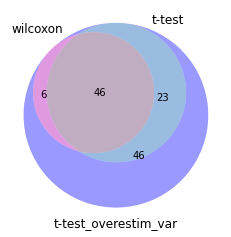

6 1 wilcoxon
6 1 t-test
6 1 t-test_overestim_var


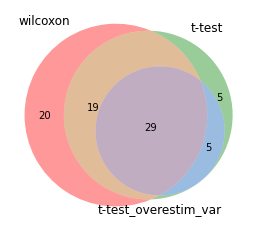

['2', '6']


Trying to set attribute `.uns` of view, copying.


2 6 wilcoxon
2 6 t-test
2 6 t-test_overestim_var


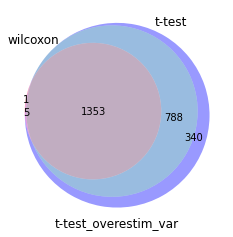

6 2 wilcoxon
6 2 t-test
6 2 t-test_overestim_var


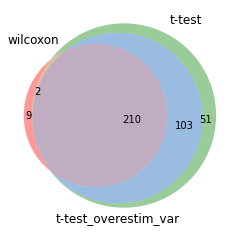

['3', '6']


Trying to set attribute `.uns` of view, copying.


3 6 wilcoxon
3 6 t-test
3 6 t-test_overestim_var


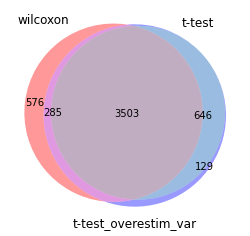

6 3 wilcoxon
6 3 t-test
6 3 t-test_overestim_var


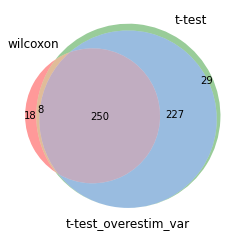

['4', '6']


Trying to set attribute `.uns` of view, copying.


4 6 wilcoxon
4 6 t-test
4 6 t-test_overestim_var


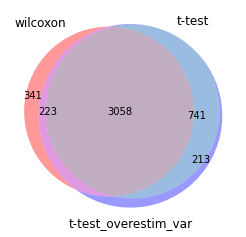

6 4 wilcoxon
6 4 t-test
6 4 t-test_overestim_var


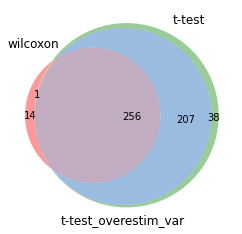

['5', '6']


Trying to set attribute `.uns` of view, copying.


5 6 wilcoxon
5 6 t-test
5 6 t-test_overestim_var


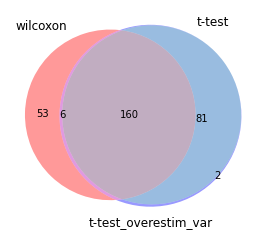

6 5 wilcoxon
6 5 t-test
6 5 t-test_overestim_var


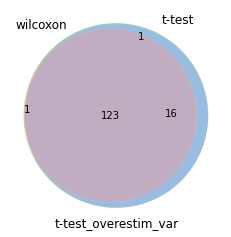

['6', '7']


Trying to set attribute `.uns` of view, copying.


6 7 wilcoxon
6 7 t-test
6 7 t-test_overestim_var


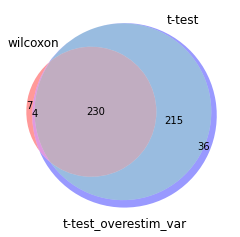

7 6 wilcoxon
7 6 t-test
7 6 t-test_overestim_var


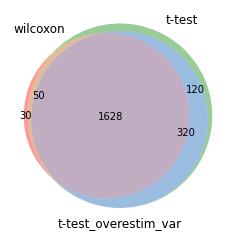

['6', '8']


Trying to set attribute `.uns` of view, copying.


6 8 wilcoxon
6 8 t-test
6 8 t-test_overestim_var


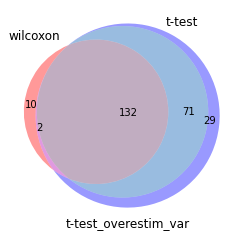

8 6 wilcoxon
8 6 t-test
8 6 t-test_overestim_var


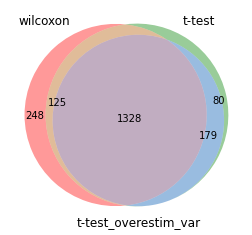

['6', '9']


Trying to set attribute `.uns` of view, copying.


6 9 wilcoxon
6 9 t-test
6 9 t-test_overestim_var


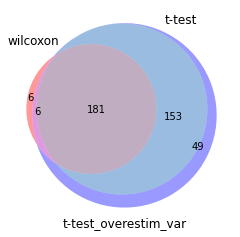

9 6 wilcoxon
9 6 t-test
9 6 t-test_overestim_var


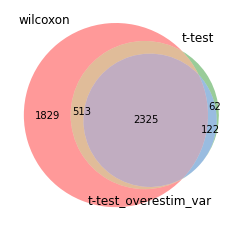

['0', '7']


Trying to set attribute `.uns` of view, copying.


0 7 wilcoxon
0 7 t-test
0 7 t-test_overestim_var


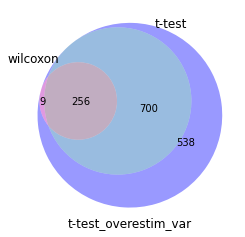

7 0 wilcoxon
7 0 t-test
7 0 t-test_overestim_var


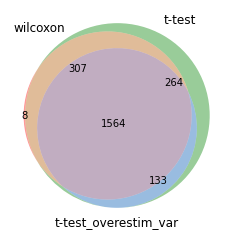

['1', '7']


Trying to set attribute `.uns` of view, copying.


1 7 wilcoxon
1 7 t-test
1 7 t-test_overestim_var


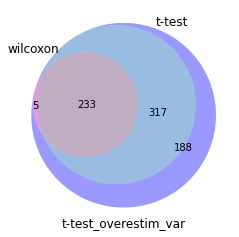

7 1 wilcoxon
7 1 t-test
7 1 t-test_overestim_var


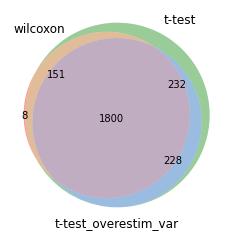

['2', '7']


Trying to set attribute `.uns` of view, copying.


2 7 wilcoxon
2 7 t-test
2 7 t-test_overestim_var


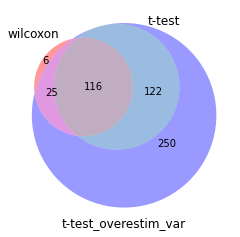

7 2 wilcoxon
7 2 t-test
7 2 t-test_overestim_var


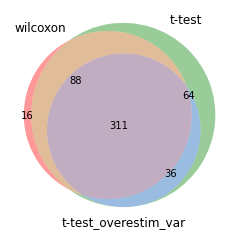

['3', '7']


Trying to set attribute `.uns` of view, copying.


3 7 wilcoxon
3 7 t-test
3 7 t-test_overestim_var


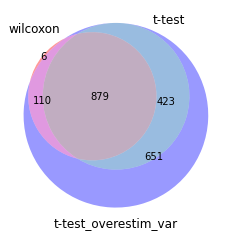

7 3 wilcoxon
7 3 t-test
7 3 t-test_overestim_var


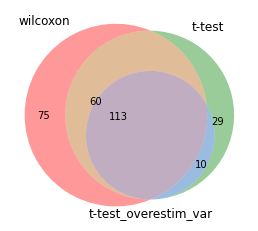

['4', '7']


Trying to set attribute `.uns` of view, copying.


4 7 wilcoxon
4 7 t-test
4 7 t-test_overestim_var


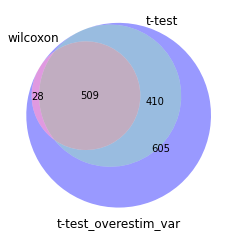

7 4 wilcoxon
7 4 t-test
7 4 t-test_overestim_var


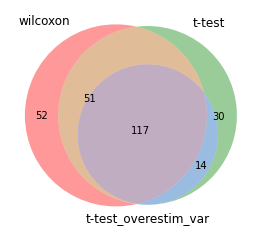

['5', '7']


Trying to set attribute `.uns` of view, copying.


5 7 wilcoxon
5 7 t-test
5 7 t-test_overestim_var


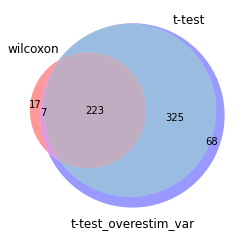

7 5 wilcoxon
7 5 t-test
7 5 t-test_overestim_var


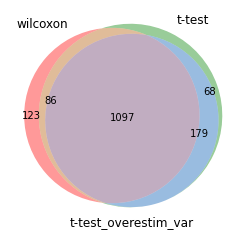

['6', '7']


Trying to set attribute `.uns` of view, copying.


6 7 wilcoxon
6 7 t-test
6 7 t-test_overestim_var


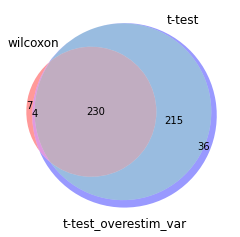

7 6 wilcoxon
7 6 t-test
7 6 t-test_overestim_var


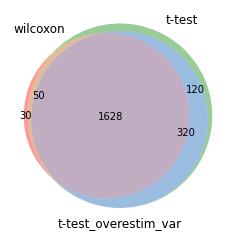

['7', '8']


Trying to set attribute `.uns` of view, copying.


7 8 wilcoxon
7 8 t-test
7 8 t-test_overestim_var


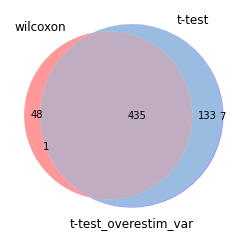

8 7 wilcoxon
8 7 t-test
8 7 t-test_overestim_var


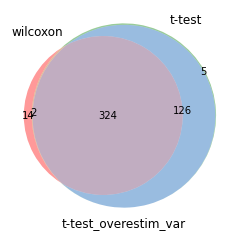

['7', '9']


Trying to set attribute `.uns` of view, copying.


7 9 wilcoxon
7 9 t-test
7 9 t-test_overestim_var


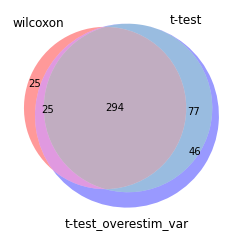

9 7 wilcoxon
9 7 t-test
9 7 t-test_overestim_var


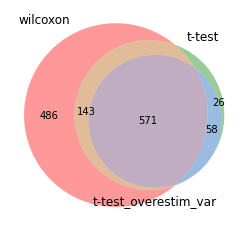

['0', '8']


Trying to set attribute `.uns` of view, copying.


0 8 wilcoxon
0 8 t-test
0 8 t-test_overestim_var


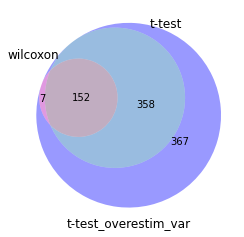

8 0 wilcoxon
8 0 t-test
8 0 t-test_overestim_var


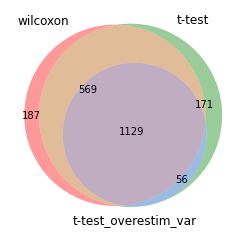

['1', '8']


Trying to set attribute `.uns` of view, copying.


1 8 wilcoxon
1 8 t-test
1 8 t-test_overestim_var


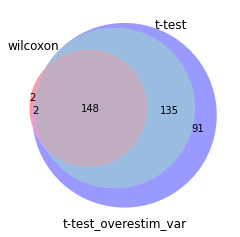

8 1 wilcoxon
8 1 t-test
8 1 t-test_overestim_var


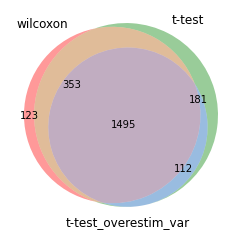

['2', '8']


Trying to set attribute `.uns` of view, copying.


2 8 wilcoxon
2 8 t-test
2 8 t-test_overestim_var


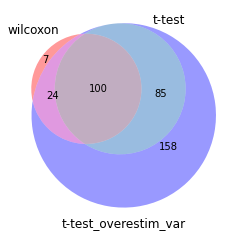

8 2 wilcoxon
8 2 t-test
8 2 t-test_overestim_var


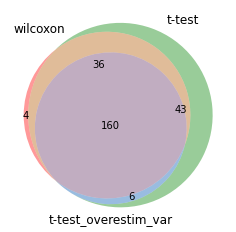

['3', '8']


Trying to set attribute `.uns` of view, copying.


3 8 wilcoxon
3 8 t-test
3 8 t-test_overestim_var


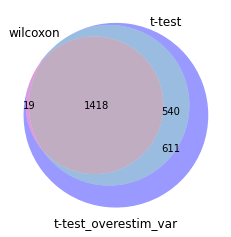

8 3 wilcoxon
8 3 t-test
8 3 t-test_overestim_var


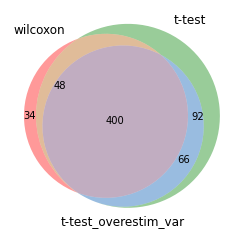

['4', '8']


Trying to set attribute `.uns` of view, copying.


4 8 wilcoxon
4 8 t-test
4 8 t-test_overestim_var


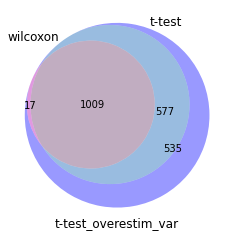

8 4 wilcoxon
8 4 t-test
8 4 t-test_overestim_var


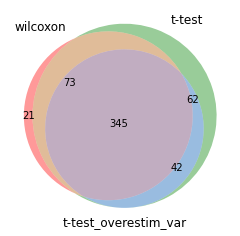

['5', '8']


Trying to set attribute `.uns` of view, copying.


5 8 wilcoxon
5 8 t-test
5 8 t-test_overestim_var


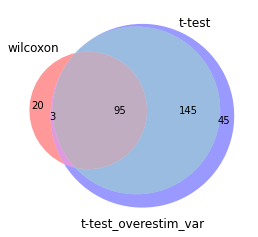

8 5 wilcoxon
8 5 t-test
8 5 t-test_overestim_var


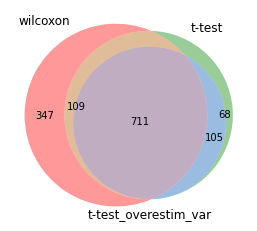

['6', '8']


Trying to set attribute `.uns` of view, copying.


6 8 wilcoxon
6 8 t-test
6 8 t-test_overestim_var


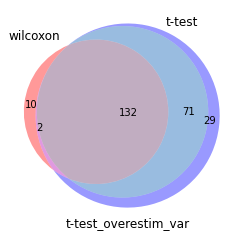

8 6 wilcoxon
8 6 t-test
8 6 t-test_overestim_var


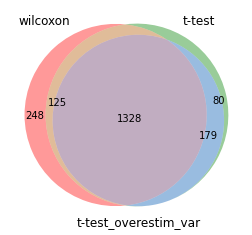

['7', '8']


Trying to set attribute `.uns` of view, copying.


7 8 wilcoxon
7 8 t-test
7 8 t-test_overestim_var


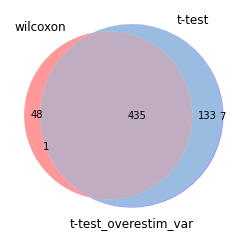

8 7 wilcoxon
8 7 t-test
8 7 t-test_overestim_var


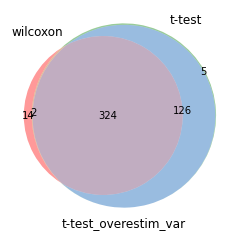

['8', '9']


Trying to set attribute `.uns` of view, copying.


8 9 wilcoxon
8 9 t-test
8 9 t-test_overestim_var


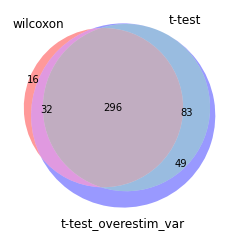

9 8 wilcoxon
9 8 t-test
9 8 t-test_overestim_var


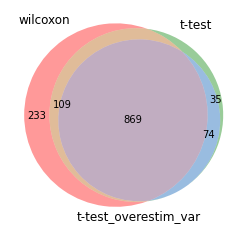

['0', '9']


Trying to set attribute `.uns` of view, copying.


0 9 wilcoxon
0 9 t-test
0 9 t-test_overestim_var


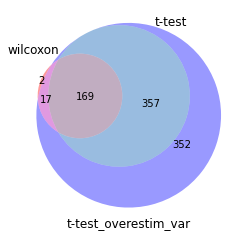

9 0 wilcoxon
9 0 t-test
9 0 t-test_overestim_var


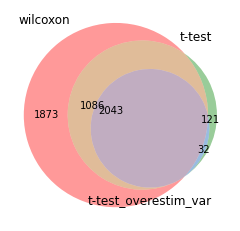

['1', '9']


Trying to set attribute `.uns` of view, copying.


1 9 wilcoxon
1 9 t-test
1 9 t-test_overestim_var


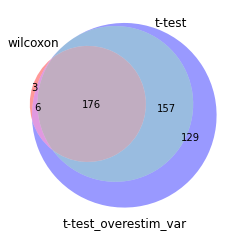

9 1 wilcoxon
9 1 t-test
9 1 t-test_overestim_var


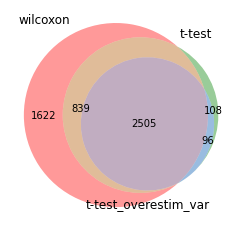

['2', '9']


Trying to set attribute `.uns` of view, copying.


2 9 wilcoxon
2 9 t-test
2 9 t-test_overestim_var


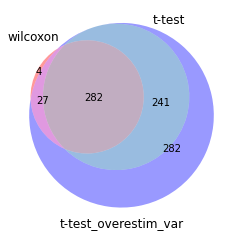

9 2 wilcoxon
9 2 t-test
9 2 t-test_overestim_var


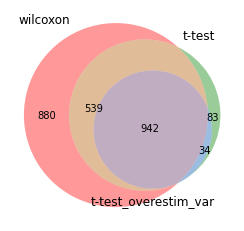

['3', '9']


Trying to set attribute `.uns` of view, copying.


3 9 wilcoxon
3 9 t-test
3 9 t-test_overestim_var


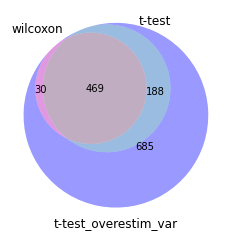

9 3 wilcoxon
9 3 t-test
9 3 t-test_overestim_var


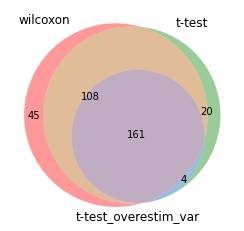

['4', '9']


Trying to set attribute `.uns` of view, copying.


4 9 wilcoxon
4 9 t-test
4 9 t-test_overestim_var


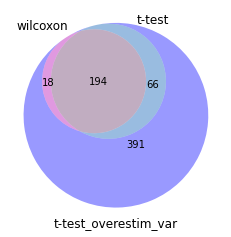

9 4 wilcoxon
9 4 t-test
9 4 t-test_overestim_var


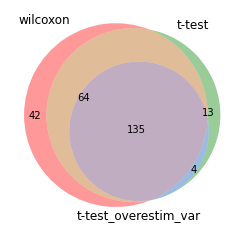

['5', '9']


Trying to set attribute `.uns` of view, copying.


5 9 wilcoxon
5 9 t-test
5 9 t-test_overestim_var


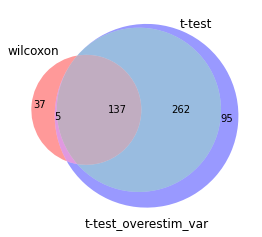

9 5 wilcoxon
9 5 t-test
9 5 t-test_overestim_var


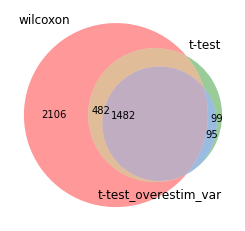

['6', '9']


Trying to set attribute `.uns` of view, copying.


6 9 wilcoxon
6 9 t-test
6 9 t-test_overestim_var


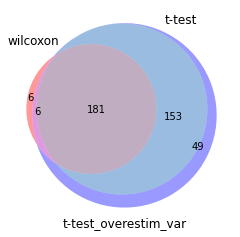

9 6 wilcoxon
9 6 t-test
9 6 t-test_overestim_var


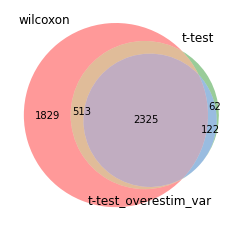

['7', '9']


Trying to set attribute `.uns` of view, copying.


7 9 wilcoxon
7 9 t-test
7 9 t-test_overestim_var


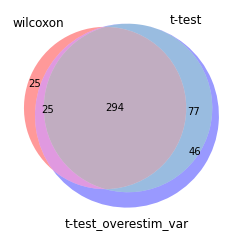

9 7 wilcoxon
9 7 t-test
9 7 t-test_overestim_var


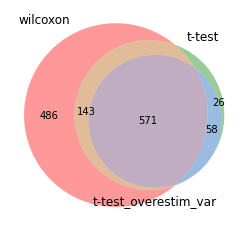

['8', '9']


Trying to set attribute `.uns` of view, copying.


8 9 wilcoxon
8 9 t-test
8 9 t-test_overestim_var


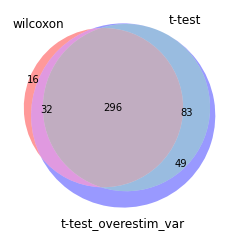

9 8 wilcoxon
9 8 t-test
9 8 t-test_overestim_var


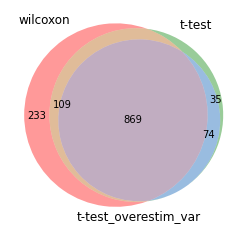

In [15]:
### Config
obs_useCol = 'louvain'
cps = ['wilcoxon', 't-test', 't-test_overestim_var']

louvain_unique = [int(x) for x in list(set(adata.obs['louvain']))]
louvain_unique.sort()
louvain_unique = [str(x) for x in louvain_unique]

### Compare
for i in louvain_unique:
    for j in louvain_unique:
        if i != j:
            adata_ij = adata.copy()
            adata_ij = adata_ij[[True if x in [i,j] else False for x in adata_ij.obs['louvain'].values],:]
            sc_addons.multitest_venn(adata_ij, cps, obs_useCol, cp_dir)